# Entrenamiento de Letras Estáticas – Lengua de Señas Mexicana
*Generado automáticamente: 2025‑06‑30 18:16*

Este cuaderno construye un **clasificador de letras estáticas** basado en **MediaPipe Hands + SVM**. Se adapta a tu estructura de proyecto (`data/letters/statics`) y guarda el modelo listo para inferencia en tiempo real.

---

## 1  Instalación de dependencias
Ejecuta esta celda **una sola vez** (puede tardar un poco si tu entorno no tiene los paquetes):

In [ ]:
!pip install mediapipe opencv-python-headless scikit-learn pandas matplotlib seaborn tqdm albumentations -q

## 2  Imports y configuración de rutas

In [1]:
import cv2, os, json, joblib, random, itertools, time, sys, math, pickle
from pathlib import Path
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Ajusta la raíz del proyecto si fuera necesario
BASE_DIR = Path('..').resolve()
STATICS_DIR = BASE_DIR / 'data' / 'statics'
CSV_PATH   = BASE_DIR / 'data' / 'letter_labels.csv'
MODEL_DIR  = BASE_DIR / 'models'
MODEL_DIR.mkdir(exist_ok=True, parents=True)
print('CSV:', CSV_PATH)


CSV: C:\Users\Jamin\Documents\Proyectos\sign-language-ml\data\letter_labels.csv


## 3  Exploración rápida del dataset

,image_path,label
0,data/statics/A/S1-A-4-0.jpg,A
1,data/statics/A/S1-A-4-1.jpg,A
2,data/statics/A/S1-A-4-10.jpg,A
3,data/statics/A/S1-A-4-100.jpg,A
4,data/statics/A/S1-A-4-101.jpg,A


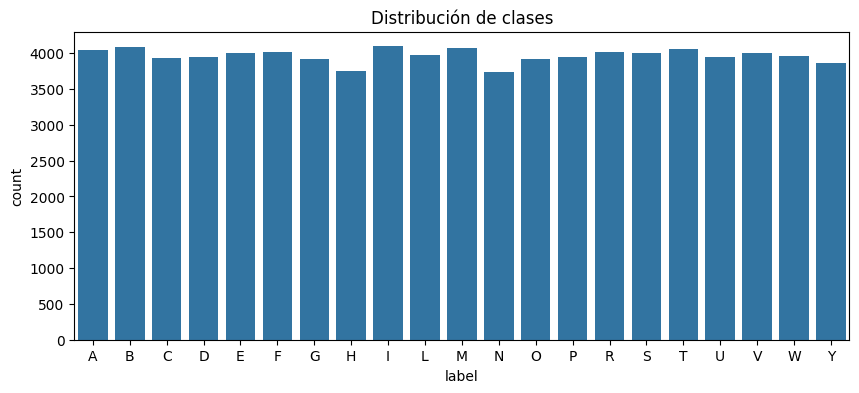

In [2]:
df = pd.read_csv(CSV_PATH)
display(df.head())
plt.figure(figsize=(10,4))
sns.countplot(x='label', data=df, order=sorted(df['label'].unique()))
plt.title('Distribución de clases')
plt.show()

### 3.1  Ejemplos visuales (uno por clase)

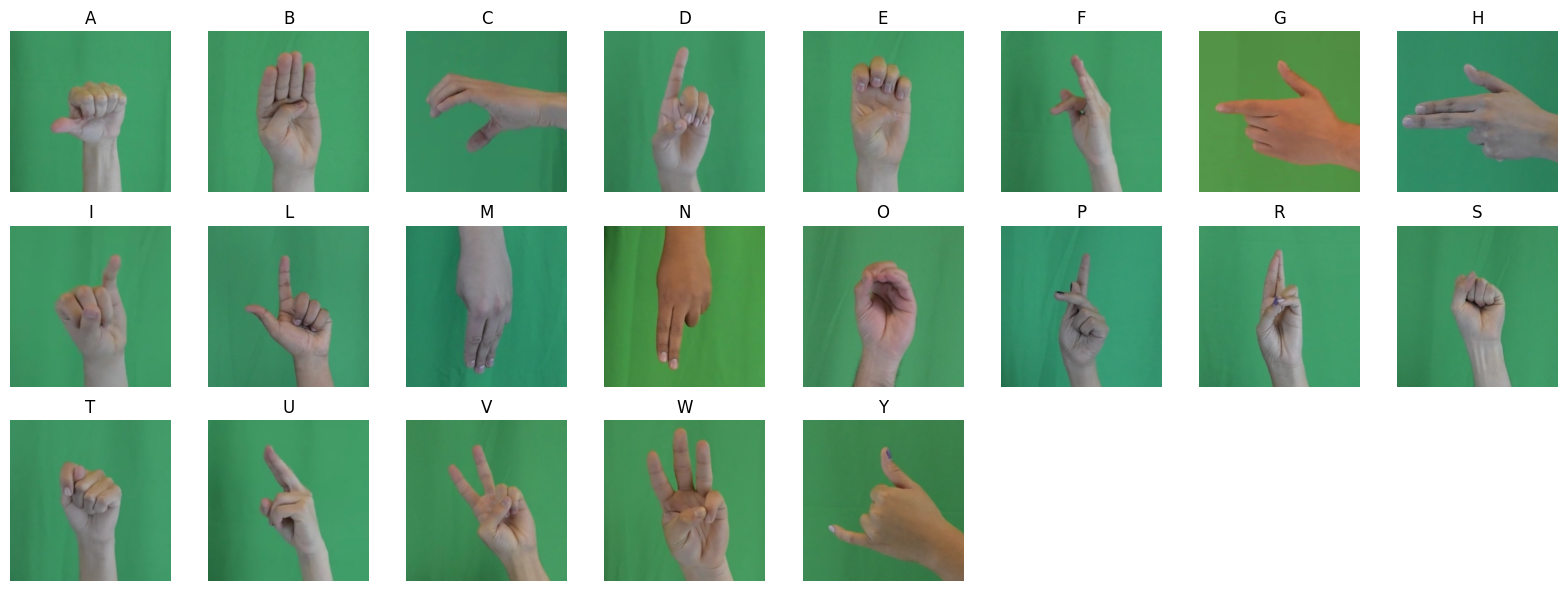

In [3]:
samples = []
for letter in sorted(df['label'].unique()):
    path = df[df['label'] == letter].sample(1, random_state=42)['image_path'].values[0]
    img = cv2.imread(str(BASE_DIR / path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    samples.append((letter, img))

cols = 8
rows = math.ceil(len(samples)/cols)
plt.figure(figsize=(cols*2, rows*2))
for idx, (letter, img) in enumerate(samples, 1):
    plt.subplot(rows, cols, idx)
    plt.imshow(img)
    plt.title(letter)
    plt.axis('off')
plt.tight_layout()
plt.show()

## 4  Extracción de características con MediaPipe Hands

In [4]:
mp_hands = mp.solutions.hands

def extract_hand_landmarks(image):
    """Devuelve un vector (63,) con x,y,z normalizados de los 21 landmarks.
    Si no detecta mano, retorna None."""
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1) as hands:
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(img_rgb)
        if not results.multi_hand_landmarks:
            return None
        lm = results.multi_hand_landmarks[0]
        coords = np.array([[p.x, p.y, p.z] for p in lm.landmark]).flatten()
        # Normalizar: traslada para que la muñeca sea (0,0,0) y escala por la distancia
        coords = coords.reshape(21,3)
        base = coords[0]
        coords -= base
        scale = np.linalg.norm(coords).mean()
        if scale > 0:
            coords /= scale
        return coords.flatten()

### 4.1  Construir `X` y `y`

In [5]:
X, y = [], []
for _, row in tqdm(df.iterrows(), total=len(df)):
    img_path = BASE_DIR / row['image_path']
    img = cv2.imread(str(img_path))
    feats = extract_hand_landmarks(img)
    if feats is not None:
        X.append(feats)
        y.append(row['label'])
    else:
        # opcional: registrar imágenes sin mano
        pass

X = np.array(X)
y = np.array(y)
print('Vector final:', X.shape)

100%|██████████| 83264/83264 [1:23:02<00:00, 16.71it/s]


Vector final: (82741, 63)


In [6]:
# Opcional: cachear para no repetir el paso costoso
np.save(MODEL_DIR / 'X_landmarks.npy', X)
np.save(MODEL_DIR / 'y_labels.npy', y)

## 5  Entrenamiento

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

In [8]:
param_grid = {
    'C': [0.1, 1, 10, 25],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}
svc = SVC(class_weight='balanced')
grid = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1, verbose=2)
grid.fit(X_train_std, y_train)
print('Mejores parámetros:', grid.best_params_)
print('Mejor accuracy CV:', grid.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores parámetros: {'C': 25, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor accuracy CV: 0.9993503721561579


### 5.1  Evaluación en el conjunto de prueba

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       808
           B       1.00      1.00      1.00       817
           C       1.00      1.00      1.00       745
           D       1.00      1.00      1.00       785
           E       1.00      1.00      1.00       798
           F       1.00      1.00      1.00       803
           G       1.00      1.00      1.00       783
           H       1.00      1.00      1.00       750
           I       1.00      1.00      1.00       817
           L       1.00      1.00      1.00       794
           M       1.00      1.00      1.00       811
           N       0.99      0.99      0.99       745
           O       1.00      1.00      1.00       778
           P       1.00      1.00      1.00       778
           R       1.00      1.00      1.00       795
           S       1.00      1.00      1.00       796
           T       1.00      1.00      1.00       812
           U       1.00    

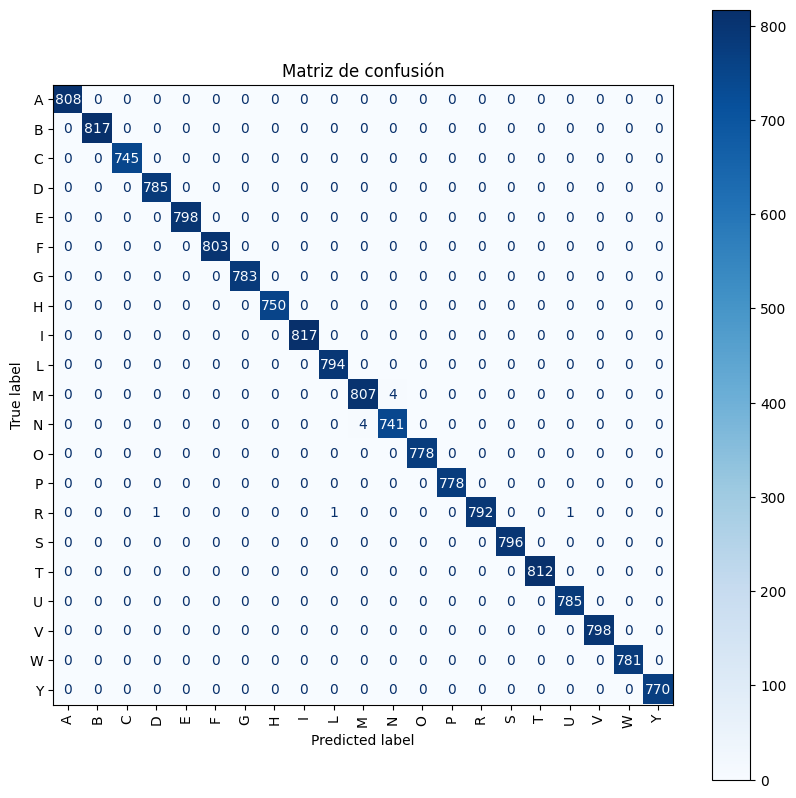

In [9]:
best_clf = grid.best_estimator_
y_pred = best_clf.predict(X_test_std)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=sorted(np.unique(y)))
disp = ConfusionMatrixDisplay(cm, display_labels=sorted(np.unique(y)))
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title('Matriz de confusión')
plt.show()

### 5.2  Guardar modelo y scaler

In [10]:
joblib.dump(best_clf, MODEL_DIR / 'letters_landmarks_svm.pkl')
joblib.dump(scaler,   MODEL_DIR / 'letters_landmarks_scaler.pkl')
print('✅ Modelo y scaler guardados en', MODEL_DIR)

✅ Modelo y scaler guardados en C:\Users\Jamin\Documents\Proyectos\sign-language-ml\models


## 6  Próximos pasos
* Implementar **data‑augmentation** para aumentar variabilidad.
* Probar un **MLP ligero** o **LightGBM** sobre los mismos landmarks.
* Integrar este modelo en el script de inferencia en tiempo real.
* Medir desempeño en campo e iterar sobre clases con peor F1.